# Feature Engineering & Selection

**Goal**: Refine features, capture "Other" events, and determine the best representation (Counts vs. Ratios).

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

In [13]:
# Load Data
df = pd.read_csv('../data/knight_hacks_dues_dataset_2025.csv')
print(f"Original Shape: {df.shape}")

Original Shape: (838, 26)


## 1. Event Feature Refinement
We identified that Workshops and Socials don't sum up to `events_attended_year`. The remainder are "Other" events (GBMs, Kickoffs, etc.).

In [14]:
# 1.1 Calculate 'Other' Events
df['n_other_events'] = df['events_attended_year'] - (df['n_workshops_year'] + df['n_socials_year'])

# Validate
print("Event Breakdown (Mean):")
print(df[['n_workshops_year', 'n_socials_year', 'n_other_events']].mean())

Event Breakdown (Mean):
n_workshops_year    0.897375
n_socials_year      0.060859
n_other_events      1.698091
dtype: float64


### 1.2 Recalculate Ratios
We will recalculate ratios to ensure consistency. 
Logic: `count / total`. If `total == 0`, ratio is `0`.

In [15]:
def calc_ratio(row, col_name):
    if row['events_attended_year'] == 0:
        return 0.0
    return row[col_name] / row['events_attended_year']

df['workshop_ratio'] = df.apply(lambda x: calc_ratio(x, 'n_workshops_year'), axis=1)
df['social_ratio'] = df.apply(lambda x: calc_ratio(x, 'n_socials_year'), axis=1)
df['other_ratio'] = df.apply(lambda x: calc_ratio(x, 'n_other_events'), axis=1)

# Check distribution of ratios for attendees only
attendees = df[df['events_attended_year'] > 0]
print("\nRatio Stats (Attendees Only):")
print(attendees[['workshop_ratio', 'social_ratio', 'other_ratio']].describe())


Ratio Stats (Attendees Only):
       workshop_ratio  social_ratio  other_ratio
count      536.000000    536.000000   536.000000
mean         0.412651      0.021292     0.566056
std          0.415289      0.109456     0.414306
min          0.000000      0.000000     0.000000
25%          0.000000      0.000000     0.000000
50%          0.328829      0.000000     0.666667
75%          1.000000      0.000000     1.000000
max          1.000000      1.000000     1.000000


### 1.3 Counts vs Ratios: Correlation Check
Should we keep both? Let's check if they provide different signals for `y_paid_dues`.

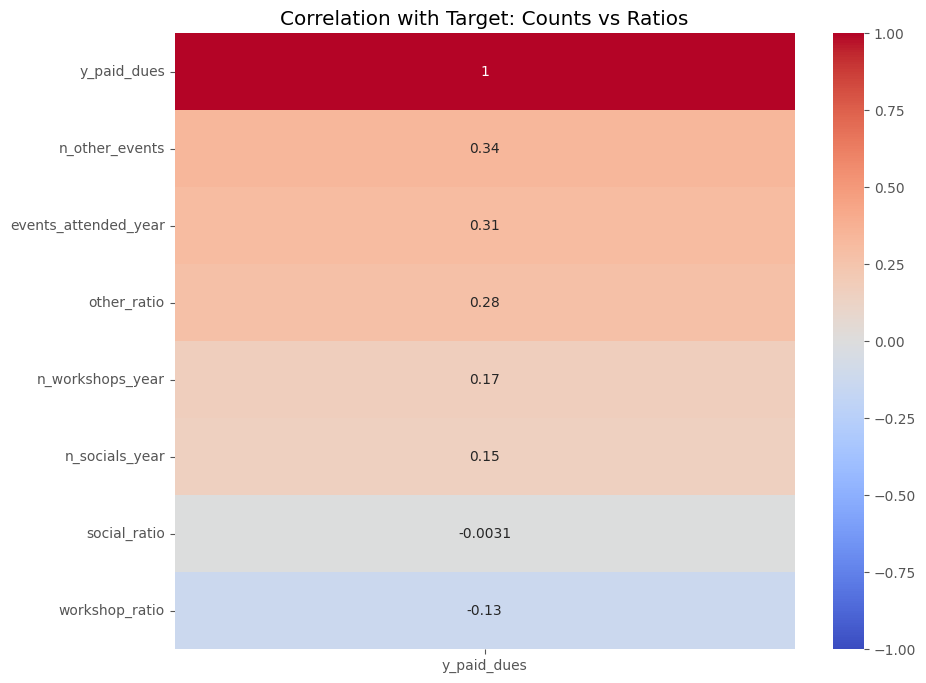

In [16]:
cols_to_check = [
    'events_attended_year',
    'n_workshops_year', 'workshop_ratio',
    'n_socials_year', 'social_ratio',
    'n_other_events', 'other_ratio',
    'y_paid_dues'
]

corr_matrix = df[cols_to_check].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[['y_paid_dues']].sort_values(by='y_paid_dues', ascending=False), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with Target: Counts vs Ratios')
plt.show()

**Decision**: We will likely keep **Counts** and **Total Events**. Ratios are good for interaction but might be redundant. If XGBoost is the goal, we can keep both and let the model decide, or just Counts.

## 2. Cleaning Categoricals & Imputation
(Continuing with previous plan)

In [17]:
# Impute other missing values
df['avg_event_rating_given'] = df['avg_event_rating_given'].fillna(df['avg_event_rating_given'].mean())
df['discord_days_since_join'] = df['discord_days_since_join'].fillna(-1)

# Grouping Categoricals
def group_school(s):
    if pd.isna(s): return 'Other'
    if 'Central Florida' in s or 'UCF' in s: return 'UCF'
    return 'Other'

def group_major(m):
    if pd.isna(m): return 'Other'
    m_lower = m.lower()
    tech_keywords = ['computer', 'software', 'information', 'data', 'cyber', 'web', 'robotics']
    if any(k in m_lower for k in tech_keywords): return 'Tech'
    return 'Other'

def group_level(l):
    if pd.isna(l): return 'Other'
    if 'Undergraduate' in l: return 'Undergraduate'
    return 'Grad/Other'

df['school_grouped'] = df['school'].apply(group_school)
df['major_grouped'] = df['major'].apply(group_major)
df['level_grouped'] = df['level_of_study'].apply(group_level)

# Tenure
df['tenure_years'] = df['member_days_since_join'] / 365.0

# Discord Active Flag
df['is_discord_active'] = (df['discord_msgs_year'] > 0).astype(int)

## 3. Final Dataset Preparation

In [18]:
cols_to_drop = [
    'discordUser', 'school', 'major', 'level_of_study', 'gender', 'race_or_ethnicity'
]

df_clean = df.drop(columns=cols_to_drop)
print(f"Final Shape: {df_clean.shape}")
df_clean.head()

Final Shape: (838, 27)


,member_days_since_join,events_attended_year,distinct_event_days_year,attendance_streak_weeks,n_workshops_year,n_socials_year,workshop_ratio,social_ratio,feedback_count_year,avg_event_rating_given,left_any_feedback,has_gone_to_hackathon,discord_member,discord_days_since_join,has_role_ops,discord_msgs_year,discord_active_days_year,discord_channels_posted_year,discord_num_roles,y_paid_dues,n_other_events,other_ratio,school_grouped,major_grouped,level_grouped,tenure_years,is_discord_active
0,84,0,0,0,0,0,0.000000,0.000000,0,9.084256,0,0,1,1177.0,0,0,0,0,12,1,0,0.000000,UCF,Tech,Undergraduate,0.230137,0
1,74,6,6,3,0,1,0.000000,0.166667,0,9.084256,0,1,1,142.0,1,1594,45,9,18,1,5,0.833333,UCF,Tech,Undergraduate,0.202740,1
2,64,0,0,0,0,0,0.000000,0.000000,0,9.084256,0,1,1,443.0,0,0,0,0,7,1,0,0.000000,UCF,Tech,Undergraduate,0.175342,0
3,308,14,13,9,1,0,0.071429,0.000000,0,9.084256,0,1,1,449.0,1,3328,161,13,15,1,13,0.928571,UCF,Tech,Undergraduate,0.843836,1
4,308,8,8,3,3,0,0.375000,0.000000,0,9.084256,0,1,1,414.0,0,2,1,1,5,1,5,0.625000,UCF,Tech,Undergraduate,0.843836,1


In [19]:
output_path = '../data/knight_hacks_dues_processed.csv'
df_clean.to_csv(output_path, index=False)
print(f"Saved processed data to {output_path}")

Saved processed data to ../data/knight_hacks_dues_processed.csv
